# Mount Google Drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install necessary libraries (run only once)
!pip install librosa pydub matplotlib scikit-learn tensorflow


In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# For ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# For DL models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.utils import to_categorical


In [4]:
import os
import librosa
import numpy as np

DATA_PATH = '/content/drive/MyDrive/Dataset/'
SAMPLE_RATE = 16000
DURATION = 3  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def extract_mfcc(file_path, n_mfcc=40):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True, duration=DURATION)
        if len(audio) < SAMPLES_PER_TRACK:
            pad_width = SAMPLES_PER_TRACK - len(audio)
            audio = np.pad(audio, (0, pad_width))
        else:
            audio = audio[:SAMPLES_PER_TRACK]

        # CORRECT way to extract MFCCs
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [ ]:
X_mfcc_mean = []
X_mfcc_raw = []
y = []

for label in os.listdir(DATA_PATH):
    folder = os.path.join(DATA_PATH, label)
    if not os.path.isdir(folder):
        continue
    for file in os.listdir(folder):
        if file.endswith('.wav'):
            file_path = os.path.join(folder, file)
            mfcc = extract_mfcc(file_path)
            if mfcc is not None:
                X_mfcc_mean.append(np.mean(mfcc.T, axis=0))  # ML version
                X_mfcc_raw.append(mfcc)                      # DL version
                y.append(label)


In [ ]:
# Convert to NumPy arrays
X_mfcc_mean = np.array(X_mfcc_mean)
X_mfcc_raw = np.array(X_mfcc_raw)
y = np.array(y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # For DL

# Save label mappings
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_map)


Label Mapping: {np.str_('Accidents'): np.int64(0), np.str_('Ambulance'): np.int64(1), np.str_('Firetruck'): np.int64(2), np.str_('Gun Shots'): np.int64(3), np.str_('Other'): np.int64(4), np.str_('Police'): np.int64(5)}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_mfcc_mean, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))


Random Forest Classification Report:
              precision    recall  f1-score   support

   Accidents       0.90      0.94      0.92       201
   Ambulance       0.73      0.72      0.73       200
   Firetruck       0.74      0.71      0.73       200
   Gun Shots       0.92      0.95      0.94       208
       Other       0.94      0.91      0.93       198
      Police       0.84      0.84      0.84        91

    accuracy                           0.85      1098
   macro avg       0.85      0.85      0.85      1098
weighted avg       0.85      0.85      0.85      1098



In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))


SVM Classification Report:
              precision    recall  f1-score   support

   Accidents       0.89      0.94      0.91       201
   Ambulance       0.77      0.77      0.77       200
   Firetruck       0.76      0.79      0.77       200
   Gun Shots       0.95      0.96      0.96       208
       Other       0.97      0.92      0.94       198
      Police       0.92      0.85      0.88        91

    accuracy                           0.87      1098
   macro avg       0.88      0.87      0.87      1098
weighted avg       0.87      0.87      0.87      1098



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))


KNN Classification Report:
              precision    recall  f1-score   support

   Accidents       0.82      0.96      0.88       201
   Ambulance       0.66      0.69      0.67       200
   Firetruck       0.69      0.58      0.63       200
   Gun Shots       0.91      0.94      0.92       208
       Other       0.81      0.78      0.79       198
      Police       0.70      0.63      0.66        91

    accuracy                           0.78      1098
   macro avg       0.76      0.76      0.76      1098
weighted avg       0.77      0.78      0.77      1098



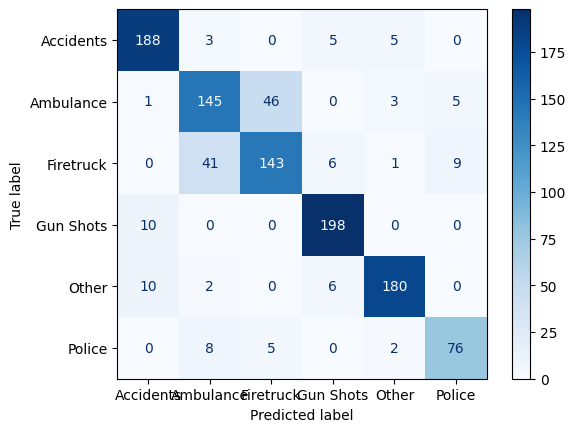

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=le.classes_, cmap='Blues')


In [ ]:
from sklearn.model_selection import train_test_split

# Ensure consistent shape (e.g., all MFCCs are 40 x 94)
X = np.array(X_mfcc_raw)
y = y_categorical

print("MFCC Shape (1 sample):", X[0].shape)  # Expect (n_mfcc, time_frames)

# Add channel dimension for CNN (samples, height, width, channels)
X = X[..., np.newaxis]

# Train-test split
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X shape for CNN:", X_train_dl.shape)


MFCC Shape (1 sample): (40, 94)
X shape for CNN: (4390, 40, 94, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = X_train_dl.shape[1:]

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 38, 92, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 19, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 22, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 22, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 11264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,441,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,461,510 (5.58 MB)

 Trainable params: 1,461,510 (5.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    X_train_dl, y_train_dl,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4528 - loss: 7.4916

110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 220ms/step - accuracy: 0.4535 - loss: 7.4508 - val_accuracy: 0.6948 - val_loss: 1.0346
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6872 - loss: 0.7841

110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.6873 - loss: 0.7837 - val_accuracy: 0.7494 - val_loss: 0.6117
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7665 - loss: 0.5825

110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.7666 - loss: 0.5824 - val_accuracy: 0.8041 - val_loss: 0.5421
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8148 - loss: 0.4771

110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 0.8148 - loss: 0.4771 - val_accuracy: 0.8030 - val_loss: 0.4713
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8268 - loss: 0.4417

110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.8269 - loss: 0.4414 - val_accuracy: 0.8519 - val_loss: 0.4513
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8494 - loss: 0.3777

110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.8494 - loss: 0.3777 - val_accuracy: 0.8610 - val_loss: 0.3539
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - accuracy: 0.8662 - loss: 0.3132 - val_accuracy: 0.8736 - val_loss: 0.3665
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.8663 - loss: 0.3319 - val_accuracy: 0.8531 - val_loss: 0.3677
Epoch 9/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - accuracy: 0.8865 - loss: 0.2891 - val_accuracy: 0.8633 - val_loss: 0.3762
Epoch 10/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.8954 - loss: 0.2752 - val_accuracy: 0.8610 - val_loss: 0.3706
Epoch 11/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - accuracy: 0.8997 - loss: 0.2559 - val_accuracy: 0.8588 - val_loss: 0.3785


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
CNN Classification Report:
              precision    recall  f1-score   support

   Accidents       0.97      0.94      0.96       201
   Ambulance       0.78      0.88      0.82       200
   Firetruck       0.82      0.70      0.76       200
   Gun Shots       0.94      0.98      0.96       208
       Other       0.97      0.98      0.98       198
      Police       0.88      0.87      0.87        91

    accuracy                           0.90      1098
   macro avg       0.89      0.89      0.89      1098
weighted avg       0.90      0.90      0.89      1098



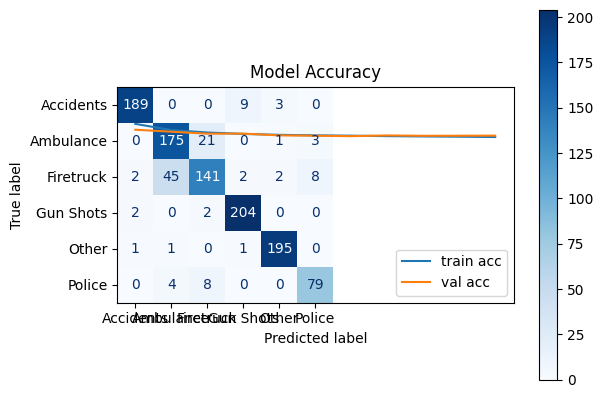

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test set
y_pred_dl = model.predict(X_test_dl)
y_pred_classes = np.argmax(y_pred_dl, axis=1)
y_true_classes = np.argmax(y_test_dl, axis=1)

# Classification report
print("CNN Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes, display_labels=le.classes_, cmap='Blues')

# Plot training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()


In [ ]:
def extract_mfcc_with_deltas(file_path, n_mfcc=40):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True, duration=DURATION)
        if len(audio) < SAMPLES_PER_TRACK:
            pad_width = SAMPLES_PER_TRACK - len(audio)
            audio = np.pad(audio, (0, pad_width))
        else:
            audio = audio[:SAMPLES_PER_TRACK]

        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)

        mfcc_combined = np.concatenate([mfcc, delta, delta2], axis=0)  # Shape: (n_mfcc*3, time_frames)
        return mfcc_combined
    except Exception as e:
        print(f"Error: {file_path} | {e}")
        return None


In [ ]:
X_mfcc_deltas = []
y_deltas = []

for label in os.listdir(DATA_PATH):
    folder = os.path.join(DATA_PATH, label)
    if not os.path.isdir(folder):
        continue
    for file in os.listdir(folder):
        if file.endswith('.wav'):
            file_path = os.path.join(folder, file)
            mfcc_features = extract_mfcc_with_deltas(file_path)
            if mfcc_features is not None:
                X_mfcc_deltas.append(mfcc_features)
                y_deltas.append(label)


In [ ]:
X_mfcc_deltas = np.array(X_mfcc_deltas)
y_deltas = np.array(y_deltas)

# Encode labels
le_deltas = LabelEncoder()
y_deltas_encoded = le_deltas.fit_transform(y_deltas)
y_deltas_categorical = to_categorical(y_deltas_encoded)

# Reshape for CNN
X_mfcc_deltas = X_mfcc_deltas[..., np.newaxis]

# Train-test split
X_train_deltas, X_test_deltas, y_train_deltas, y_test_deltas = train_test_split(
    X_mfcc_deltas, y_deltas_categorical, test_size=0.2, random_state=42, stratify=y_deltas_encoded
)

print("Input shape for CNN with deltas:", X_train_deltas.shape)


Input shape for CNN with deltas: (4390, 120, 94, 1)


In [ ]:
input_shape = X_train_deltas.shape[1:]

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_deltas_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 118, 92, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 59, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 59, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 57, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 28, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 39424)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       5,046,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,065,990 (19.33 MB)

 Trainable params: 5,065,990 (19.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_deltas, y_train_deltas,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=callbacks  # reuse EarlyStopping and ModelCheckpoint if defined
)


Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 627ms/step - accuracy: 0.4505 - loss: 6.9418 - val_accuracy: 0.6629 - val_loss: 0.8089
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 663ms/step - accuracy: 0.6997 - loss: 0.7292 - val_accuracy: 0.7517 - val_loss: 0.6166
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 70s 638ms/step - accuracy: 0.7707 - loss: 0.5460 - val_accuracy: 0.8417 - val_loss: 0.4564
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 87s 679ms/step - accuracy: 0.8199 - loss: 0.4371 - val_accuracy: 0.8690 - val_loss: 0.4254
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 668ms/step - accuracy: 0.8446 - loss: 0.3997 - val_accuracy: 0.8724 - val_loss: 0.3553
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.8587 - loss: 0.3388

110/110 ━━━━━━━━━━━━━━━━━━━━ 88s 721ms/step - accuracy: 0.8587 - loss: 0.3388 - val_accuracy: 0.8918 - val_loss: 0.3192
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 75s 683ms/step - accuracy: 0.8802 - loss: 0.3013 - val_accuracy: 0.8964 - val_loss: 0.3319
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.8742 - loss: 0.2937

110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 672ms/step - accuracy: 0.8742 - loss: 0.2936 - val_accuracy: 0.9009 - val_loss: 0.2616
Epoch 9/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 79s 652ms/step - accuracy: 0.8862 - loss: 0.2630 - val_accuracy: 0.9089 - val_loss: 0.2722
Epoch 10/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 669ms/step - accuracy: 0.9033 - loss: 0.2409 - val_accuracy: 0.8941 - val_loss: 0.3071
Epoch 11/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 85s 696ms/step - accuracy: 0.8999 - loss: 0.2411 - val_accuracy: 0.9055 - val_loss: 0.2650
Epoch 12/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 78s 658ms/step - accuracy: 0.9063 - loss: 0.2158 - val_accuracy: 0.8815 - val_loss: 0.3709
Epoch 13/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.9117 - loss: 0.2226

110/110 ━━━━━━━━━━━━━━━━━━━━ 99s 822ms/step - accuracy: 0.9118 - loss: 0.2223 - val_accuracy: 0.9123 - val_loss: 0.2557
Epoch 14/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 76s 695ms/step - accuracy: 0.9348 - loss: 0.1597 - val_accuracy: 0.9180 - val_loss: 0.2887
Epoch 15/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 688ms/step - accuracy: 0.9300 - loss: 0.1530 - val_accuracy: 0.9055 - val_loss: 0.2917
Epoch 16/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 696ms/step - accuracy: 0.9349 - loss: 0.1488 - val_accuracy: 0.9191 - val_loss: 0.2566
Epoch 17/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 78s 659ms/step - accuracy: 0.9433 - loss: 0.1523 - val_accuracy: 0.8964 - val_loss: 0.3106
Epoch 18/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 654ms/step - accuracy: 0.9289 - loss: 0.1662 - val_accuracy: 0.9066 - val_loss: 0.3812


In [ ]:
y_pred_dl = model.predict(X_test_deltas)
y_pred_classes = np.argmax(y_pred_dl, axis=1)
y_true_classes = np.argmax(y_test_deltas, axis=1)

print("CNN with Delta MFCCs Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le_deltas.classes_))


35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step
CNN with Delta MFCCs Classification Report:
              precision    recall  f1-score   support

   Accidents       0.92      0.97      0.95       201
   Ambulance       0.81      0.81      0.81       200
   Firetruck       0.79      0.77      0.78       200
   Gun Shots       0.98      0.97      0.98       208
       Other       0.95      0.95      0.95       198
      Police       0.89      0.87      0.88        91

    accuracy                           0.89      1098
   macro avg       0.89      0.89      0.89      1098
weighted avg       0.89      0.89      0.89      1098



In [5]:
def extract_mel_spectrogram(file_path, n_mels=128):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True, duration=DURATION)
        if len(audio) < SAMPLES_PER_TRACK:
            pad_width = SAMPLES_PER_TRACK - len(audio)
            audio = np.pad(audio, (0, pad_width))
        else:
            audio = audio[:SAMPLES_PER_TRACK]

        # Compute Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale
        return mel_spec_db
    except Exception as e:
        print(f"Error: {file_path} | {e}")
        return None


In [6]:
X_mel = []
y_mel = []

for label in os.listdir(DATA_PATH):
    folder = os.path.join(DATA_PATH, label)
    if not os.path.isdir(folder):
        continue
    for file in os.listdir(folder):
        if file.endswith('.wav'):
            file_path = os.path.join(folder, file)
            mel_features = extract_mel_spectrogram(file_path)
            if mel_features is not None:
                X_mel.append(mel_features)
                y_mel.append(label)


In [8]:
X_mel = np.array(X_mel)
y_mel = np.array(y_mel)

# Encode labels
le_mel = LabelEncoder()
y_mel_encoded = le_mel.fit_transform(y_mel)
y_mel_categorical = to_categorical(y_mel_encoded)

# Reshape for CNN (samples, height, width, 1)
X_mel = X_mel[..., np.newaxis]

# Train-test split
X_train_mel, X_test_mel, y_train_mel, y_test_mel = train_test_split(
    X_mel, y_mel_categorical, test_size=0.2, random_state=42, stratify=y_mel_encoded
)

print("Input shape for Mel Spectrogram CNN:", X_train_mel.shape)


Input shape for Mel Spectrogram CNN: (4390, 128, 94, 1)


In [ ]:
input_shape = X_train_mel.shape[1:]

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_mel_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 92, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 42240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,406,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,426,438 (20.70 MB)

 Trainable params: 5,426,438 (20.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_mel, y_train_mel,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=callbacks  # optional: EarlyStopping, ModelCheckpoint
)


Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 79s 685ms/step - accuracy: 0.3509 - loss: 20.9488 - val_accuracy: 0.6549 - val_loss: 1.1335
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 690ms/step - accuracy: 0.6609 - loss: 0.9291 - val_accuracy: 0.7358 - val_loss: 0.7022
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 75s 677ms/step - accuracy: 0.7589 - loss: 0.6641 - val_accuracy: 0.7620 - val_loss: 0.5784
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 89s 744ms/step - accuracy: 0.8038 - loss: 0.5132 - val_accuracy: 0.8144 - val_loss: 0.5197
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 729ms/step - accuracy: 0.8456 - loss: 0.4124 - val_accuracy: 0.8349 - val_loss: 0.4569
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 78s 694ms/step - accuracy: 0.8641 - loss: 0.3512 - val_accuracy: 0.8690 - val_loss: 0.3672
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 706ms/step - accuracy: 0.8872 - loss: 0.3031 - val_accuracy: 0.8599 - val_loss: 0.4023
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 690ms/step - accuracy: 0.9013 - loss: 

In [ ]:
y_pred_mel = model.predict(X_test_mel)
y_pred_classes = np.argmax(y_pred_mel, axis=1)
y_true_classes = np.argmax(y_test_mel, axis=1)

print("Mel Spectrogram CNN Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le_mel.classes_))


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step
Mel Spectrogram CNN Classification Report:
              precision    recall  f1-score   support

   Accidents       0.97      0.97      0.97       201
   Ambulance       0.84      0.71      0.77       200
   Firetruck       0.73      0.78      0.75       200
   Gun Shots       0.98      0.98      0.98       208
       Other       0.87      0.94      0.90       198
      Police       0.89      0.89      0.89        91

    accuracy                           0.88      1098
   macro avg       0.88      0.88      0.88      1098
weighted avg       0.88      0.88      0.88      1098



In [ ]:
!pip install audiomentations


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of numpy-minmax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numpy-rms to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain
import librosa

AUGMENT = Compose([
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    Gain(min_gain_db=-6, max_gain_db=6, p=0.5),
    Shift(min_shift=-0.1, max_shift=0.1, p=0.5)
])


In [ ]:
def extract_augmented_mel(file_path, apply_augment=False, n_mels=128):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True, duration=DURATION)

        if len(audio) < SAMPLES_PER_TRACK:
            pad_width = SAMPLES_PER_TRACK - len(audio)
            audio = np.pad(audio, (0, pad_width))
        else:
            audio = audio[:SAMPLES_PER_TRACK]

        if apply_augment:
            audio = AUGMENT(samples=audio, sample_rate=sr)

        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        return mel_spec_db
    except Exception as e:
        print(f"Error: {file_path} | {e}")
        return None


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, augment=False, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = [], []

        for path, label in zip(batch_paths, batch_labels):
            mel = extract_augmented_mel(path, apply_augment=self.augment)
            if mel is not None:
                X.append(mel[..., np.newaxis])  # Add channel
                y.append(label)

        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.file_paths, self.labels))
            random.shuffle(temp)
            self.file_paths, self.labels = zip(*temp)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create file paths and encoded labels
all_files = []
all_labels = []

for label in os.listdir(DATA_PATH):
    folder = os.path.join(DATA_PATH, label)
    if not os.path.isdir(folder): continue
    for file in os.listdir(folder):
        if file.endswith('.wav'):
            all_files.append(os.path.join(folder, file))
            all_labels.append(label)

# Encode
le_aug = LabelEncoder()
labels_encoded = le_aug.fit_transform(all_labels)
labels_onehot = to_categorical(labels_encoded)

# Train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_files, labels_onehot, test_size=0.2, random_state=42, stratify=labels_encoded
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_augmented_model.h5', save_best_only=True)
]


In [ ]:
# Create data generators
train_gen = AudioDataGenerator(train_paths, train_labels, batch_size=32, augment=True)
val_gen = AudioDataGenerator(test_paths, test_labels, batch_size=32, augment=False)

# Train
model.fit(train_gen,
          validation_data=val_gen,
          epochs=30,
          callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2405 - loss: 40.2539

138/138 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.2409 - loss: 40.0462 - val_accuracy: 0.2969 - val_loss: 1.6883
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4076 - loss: 1.4862

138/138 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.4077 - loss: 1.4858 - val_accuracy: 0.4581 - val_loss: 1.4556
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5522 - loss: 1.1711

138/138 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.5523 - loss: 1.1708 - val_accuracy: 0.6011 - val_loss: 1.0823
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6350 - loss: 0.9387

138/138 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.6351 - loss: 0.9386 - val_accuracy: 0.6967 - val_loss: 0.8436
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6983 - loss: 0.8217

138/138 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.6982 - loss: 0.8219 - val_accuracy: 0.7168 - val_loss: 0.7927
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.6995 - loss: 0.7744 - val_accuracy: 0.7095 - val_loss: 0.8151
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7186 - loss: 0.7257

138/138 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.7186 - loss: 0.7257 - val_accuracy: 0.7131 - val_loss: 0.7511
Epoch 8/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7460 - loss: 0.6728

138/138 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.7459 - loss: 0.6730 - val_accuracy: 0.7404 - val_loss: 0.6917
Epoch 9/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7364 - loss: 0.6878

138/138 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - accuracy: 0.7364 - loss: 0.6876 - val_accuracy: 0.7687 - val_loss: 0.6170
Epoch 10/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.7484 - loss: 0.6344 - val_accuracy: 0.7268 - val_loss: 0.7219
Epoch 11/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7610 - loss: 0.6332

138/138 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.7610 - loss: 0.6332 - val_accuracy: 0.7787 - val_loss: 0.5781
Epoch 12/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7795 - loss: 0.5626

138/138 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.7795 - loss: 0.5626 - val_accuracy: 0.8242 - val_loss: 0.4976
Epoch 13/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.7848 - loss: 0.5481 - val_accuracy: 0.8078 - val_loss: 0.5096
Epoch 14/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.7955 - loss: 0.5596 - val_accuracy: 0.7887 - val_loss: 0.5622
Epoch 15/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8027 - loss: 0.5226

138/138 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.8027 - loss: 0.5226 - val_accuracy: 0.8242 - val_loss: 0.4908
Epoch 16/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.8085 - loss: 0.4990 - val_accuracy: 0.8151 - val_loss: 0.4969
Epoch 17/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8227 - loss: 0.4857

138/138 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.8226 - loss: 0.4859 - val_accuracy: 0.8324 - val_loss: 0.4515
Epoch 18/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8154 - loss: 0.4673

138/138 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.8155 - loss: 0.4673 - val_accuracy: 0.8497 - val_loss: 0.4093
Epoch 19/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.8214 - loss: 0.4735 - val_accuracy: 0.8124 - val_loss: 0.5372
Epoch 20/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step - accuracy: 0.8393 - loss: 0.4188 - val_accuracy: 0.8397 - val_loss: 0.4314
Epoch 21/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.8320 - loss: 0.4625 - val_accuracy: 0.8525 - val_loss: 0.4229
Epoch 22/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8433 - loss: 0.4256

138/138 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.8432 - loss: 0.4257 - val_accuracy: 0.8625 - val_loss: 0.4050
Epoch 23/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.8281 - loss: 0.4255 - val_accuracy: 0.8506 - val_loss: 0.4119
Epoch 24/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step - accuracy: 0.8520 - loss: 0.3962 - val_accuracy: 0.8534 - val_loss: 0.4345
Epoch 25/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.8408 - loss: 0.4053 - val_accuracy: 0.8588 - val_loss: 0.4141
Epoch 26/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8538 - loss: 0.4038

138/138 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.8537 - loss: 0.4038 - val_accuracy: 0.8798 - val_loss: 0.3805
Epoch 27/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.8674 - loss: 0.3553 - val_accuracy: 0.8634 - val_loss: 0.3838
Epoch 28/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.8602 - loss: 0.3821 - val_accuracy: 0.8597 - val_loss: 0.4089
Epoch 29/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8461 - loss: 0.4034

138/138 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.8461 - loss: 0.4033 - val_accuracy: 0.8770 - val_loss: 0.3797
Epoch 30/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.8624 - loss: 0.3559 - val_accuracy: 0.8698 - val_loss: 0.3940


In [1]:
y_pred_mel = model.predict(X_test_mel)
y_pred_classes = np.argmax(y_pred_mel, axis=1)
y_true_classes = np.argmax(y_test_mel, axis=1)

print("Mel Spectrogram CNN Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le_mel.classes_))


NameError: name 'model' is not defined

In [ ]:
# Save to your Drive
model.save('/content/drive/MyDrive/best_augmented_model.h5')


In [ ]:
import joblib

# Save label encoder
joblib.dump(le_aug, '/content/drive/MyDrive/label_encoder_augmented.pkl')


['/content/drive/MyDrive/label_encoder_augmented.pkl']

In [9]:
# Ensure shape: (samples, time_steps, features, channels)
X_seq = X_mel  # Already shaped (samples, 128, time_frames, 1)

# Reshape for TimeDistributed CNN → LSTM
time_steps = X_seq.shape[2]  # width
height = X_seq.shape[1]      # 128 mel bands

# New shape: (samples, time_steps, height, channels)
X_seq = np.transpose(X_seq, (0, 2, 1, 3))  # (batch, time, height, 1)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import LSTM, Dense, Dropout

input_shape = X_seq.shape[1:]  # (time_steps, height, 1)
num_classes = y_mel_categorical.shape[1]

model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.3)),

    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.3)),

    TimeDistributed(Flatten()),

    LSTM(128, return_sequences=False),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


ValueError: Kernel shape must have the same length as input, but received kernel of shape (3, 3, 1, 32) and input of shape (None, 128, 1).

In [39]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [40]:
SAMPLE_RATE = 16000
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def extract_mel_spectrogram(file_path, n_mels=128):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True, duration=DURATION)
        if len(audio) < SAMPLES_PER_TRACK:
            audio = np.pad(audio, (0, SAMPLES_PER_TRACK - len(audio)))
        else:
            audio = audio[:SAMPLES_PER_TRACK]
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db  # (n_mels, time_frames)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [41]:
X_raw = []
y_raw = []

for label in os.listdir(DATA_PATH):
    folder = os.path.join(DATA_PATH, label)
    if not os.path.isdir(folder): continue
    for file in os.listdir(folder):
        if file.endswith('.wav'):
            mel = extract_mel_spectrogram(os.path.join(folder, file))
            if mel is not None:
                X_raw.append(mel)
                y_raw.append(label)

X_raw = np.array(X_raw)     # shape: (samples, n_mels, time_frames)
y_raw = np.array(y_raw)


In [42]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
y_categorical = to_categorical(y_encoded)
num_classes = y_categorical.shape[1]

# Transpose to (samples, time_steps, features) = (samples, time_frames, n_mels)
X_seq = np.transpose(X_raw, (0, 2, 1))  # final shape: (samples, time_steps, features)


In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input

model = Sequential([
    Input(shape=X_train.shape[1:]),  # (time_steps, features)
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(128),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 90, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,126 (613.77 KB)

 Trainable params: 157,126 (613.77 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn1d_lstm_model.h5', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5063 - loss: 1.1288

110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.5064 - loss: 1.1288 - val_accuracy: 0.4841 - val_loss: 1.1680
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5264 - loss: 1.0923

110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.5264 - loss: 1.0923 - val_accuracy: 0.5114 - val_loss: 1.1574
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5181 - loss: 1.0959

110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.5181 - loss: 1.0959 - val_accuracy: 0.5114 - val_loss: 1.1039
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5155 - loss: 1.1326 - val_accuracy: 0.4829 - val_loss: 1.1884
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.5388 - loss: 1.0861 - val_accuracy: 0.5296 - val_loss: 1.1218
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.5336 - loss: 1.0742 - val_accuracy: 0.5205 - val_loss: 1.1286
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.5470 - loss: 1.0451 - val_accuracy: 0.5319 - val_loss: 1.1240
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.5582 - loss: 1.0572 - val_accuracy: 0.5376 - val_loss: 1.1345


In [47]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Conv1D + LSTM Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Conv1D + LSTM Classification Report:
              precision    recall  f1-score   support

   Accidents       0.61      0.69      0.65       201
   Ambulance       0.44      0.51      0.47       200
   Firetruck       0.98      0.23      0.38       200
   Gun Shots       0.76      0.68      0.72       208
       Other       0.32      0.66      0.43       198
      Police       0.00      0.00      0.00        91

    accuracy                           0.51      1098
   macro avg       0.52      0.46      0.44      1098
weighted avg       0.57      0.51      0.49      1098



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [49]:
SAMPLE_RATE = 16000
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
DATA_PATH = '/content/drive/MyDrive/Dataset'  # Update if needed


In [50]:
def extract_mel_spectrogram(file_path, n_mels=128):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True, duration=DURATION)
        if len(audio) < SAMPLES_PER_TRACK:
            audio = np.pad(audio, (0, SAMPLES_PER_TRACK - len(audio)))
        else:
            audio = audio[:SAMPLES_PER_TRACK]
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [51]:
X_raw = []
y_raw = []

for label in os.listdir(DATA_PATH):
    folder = os.path.join(DATA_PATH, label)
    if not os.path.isdir(folder): continue
    for file in os.listdir(folder):
        if file.endswith('.wav'):
            mel = extract_mel_spectrogram(os.path.join(folder, file))
            if mel is not None:
                X_raw.append(mel)
                y_raw.append(label)

X_raw = np.array(X_raw)
y_raw = np.array(y_raw)


In [52]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
y_categorical = to_categorical(y_encoded)
num_classes = y_categorical.shape[1]

# Normalize to 0–1
X_raw = (X_raw - np.min(X_raw)) / (np.max(X_raw) - np.min(X_raw))

# Reshape for Conv1D: (samples, time_steps, features)
X_seq = np.transpose(X_raw, (0, 2, 1))  # (samples, time_frames, n_mels)


In [53]:
X_train, X_test, y_train, y_test, y_train_encoded, y_test_encoded = train_test_split(
    X_seq, y_categorical, y_encoded,
    test_size=0.2, random_state=42, stratify=y_encoded
)


In [54]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weights_dict = dict(enumerate(class_weights))


In [55]:
model = Sequential([
    Input(shape=X_train.shape[1:]),  # (time_steps, features)

    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(128),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 90, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 45, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 45, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 43, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,790 (870.27 KB)

 Trainable params: 222,790 (870.27 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('improved_cnn1d_lstm_model.h5', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=callbacks
)


Epoch 1/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3338 - loss: 1.4977

110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.3350 - loss: 1.4953 - val_accuracy: 0.4442 - val_loss: 1.2124
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4676 - loss: 1.2377

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.4676 - loss: 1.2376 - val_accuracy: 0.4522 - val_loss: 1.1942
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4776 - loss: 1.1930

110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.4777 - loss: 1.1928 - val_accuracy: 0.5626 - val_loss: 1.0955
Epoch 4/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4936 - loss: 1.1725

110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.4940 - loss: 1.1717 - val_accuracy: 0.5182 - val_loss: 1.0698
Epoch 5/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5355 - loss: 1.0772

110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.5357 - loss: 1.0770 - val_accuracy: 0.5387 - val_loss: 1.0058
Epoch 6/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5691 - loss: 1.0243

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.5691 - loss: 1.0242 - val_accuracy: 0.5592 - val_loss: 0.9866
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.5459 - loss: 1.0264 - val_accuracy: 0.5888 - val_loss: 0.9916
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5659 - loss: 0.9918

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.5659 - loss: 0.9918 - val_accuracy: 0.5695 - val_loss: 0.9288
Epoch 9/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5958 - loss: 0.9471 - val_accuracy: 0.6025 - val_loss: 0.9427
Epoch 10/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5903 - loss: 0.9735

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.5903 - loss: 0.9731 - val_accuracy: 0.5774 - val_loss: 0.8966
Epoch 11/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5945 - loss: 0.9466

110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.5946 - loss: 0.9465 - val_accuracy: 0.5991 - val_loss: 0.8762
Epoch 12/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.6229 - loss: 0.8848 - val_accuracy: 0.6082 - val_loss: 0.8774
Epoch 13/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.5964 - loss: 0.9097 - val_accuracy: 0.5934 - val_loss: 0.9230
Epoch 14/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.6169 - loss: 0.9005 - val_accuracy: 0.6185 - val_loss: 0.8800
Epoch 15/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6269 - loss: 0.8786

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.6270 - loss: 0.8786 - val_accuracy: 0.6253 - val_loss: 0.8749
Epoch 16/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.6217 - loss: 0.8819 - val_accuracy: 0.6093 - val_loss: 0.8755
Epoch 17/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6181 - loss: 0.8910

110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.6183 - loss: 0.8908 - val_accuracy: 0.6230 - val_loss: 0.8656
Epoch 18/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6432 - loss: 0.8585

110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.6433 - loss: 0.8584 - val_accuracy: 0.6173 - val_loss: 0.8217
Epoch 19/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.6591 - loss: 0.8142 - val_accuracy: 0.6367 - val_loss: 0.8259
Epoch 20/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6524 - loss: 0.8155

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.6526 - loss: 0.8153 - val_accuracy: 0.6503 - val_loss: 0.7651
Epoch 21/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.6421 - loss: 0.8311 - val_accuracy: 0.6298 - val_loss: 0.8018
Epoch 22/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.6650 - loss: 0.7958 - val_accuracy: 0.6526 - val_loss: 0.7734
Epoch 23/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.6572 - loss: 0.7972 - val_accuracy: 0.6526 - val_loss: 0.7877
Epoch 24/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6586 - loss: 0.7982

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6586 - loss: 0.7983 - val_accuracy: 0.6390 - val_loss: 0.7473
Epoch 25/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6608 - loss: 0.7975

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.6608 - loss: 0.7977 - val_accuracy: 0.6560 - val_loss: 0.7405
Epoch 26/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.6666 - loss: 0.7749 - val_accuracy: 0.6241 - val_loss: 0.8262
Epoch 27/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.6656 - loss: 0.7804 - val_accuracy: 0.6663 - val_loss: 0.7488
Epoch 28/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.6776 - loss: 0.7583 - val_accuracy: 0.6424 - val_loss: 0.7963
Epoch 29/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.6738 - loss: 0.7521 - val_accuracy: 0.6560 - val_loss: 0.7602
Epoch 30/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.6752 - loss: 0.7748 - val_accuracy: 0.6583 - val_loss: 0.7551


In [57]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Improved Conv1D + LSTM Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Improved Conv1D + LSTM Classification Report:
              precision    recall  f1-score   support

   Accidents       0.83      0.81      0.82       201
   Ambulance       0.77      0.50      0.61       200
   Firetruck       0.69      0.43      0.53       200
   Gun Shots       0.92      0.84      0.88       208
       Other       0.81      0.59      0.68       198
      Police       0.26      0.89      0.40        91

    accuracy                           0.66      1098
   macro avg       0.71      0.68      0.65      1098
weighted avg       0.76      0.66      0.68      1098

